In [1]:
# Importar paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_datareader.data as web

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [3]:
activos = ['TSLA', 'AMZN', 'MSFT', 'DIS']

In [4]:
closes = get_adj_closes(tickers=activos)

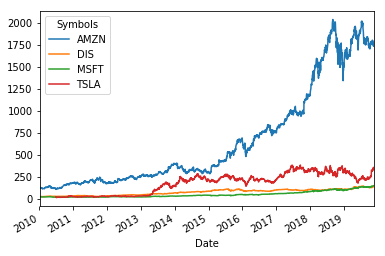

In [5]:
closes.plot()

In [6]:
ret = closes.pct_change().dropna()

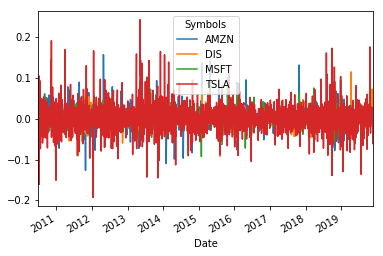

In [7]:
ret.plot()

In [8]:
Er = ret.mean()
s = ret.std

In [9]:
cov = ret.cov()

In [10]:
from scipy.optimize import minimize

In [11]:
def varianza(w, Sigma):
    return w.dot(Sigma).dot(w)

In [19]:
# Dato inicial
n = len(Er)
w0 = np.ones((n,)) / n
# Cotas de las variables
bnds = ((0, 1),) * n
# Restricciones
cons = {'type': 'eq', 'fun': lambda w: w.sum() - 1}

In [40]:
# Portafolio de mínima varianza
minvar = minimize(fun=varianza,
                  x0=w0,
                  args=(cov,),
                  bounds=bnds,
                  constraints=cons,
                  tol=1e-10
                 )
minvar

     fun: 0.00013129276856545239
     jac: array([0.00026259, 0.00026259, 0.00026259, 0.00026259])
 message: 'Optimization terminated successfully.'
    nfev: 120
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([0.07895305, 0.53727807, 0.36772638, 0.0160425 ])

In [25]:
# Función objetivo
def menos_RS(w, Sigma, rf, Eind):
    Ep = Eind.dot(w)
    sp = w.dot(Sigma).dot(w)**0.5
    RS = (Ep - rf) / sp
    return -RS

In [26]:
# Dato inicial
n = len(Er) # 5
w0 = np.ones((n,)) / n
# Cotas de las variables
bnds = ((0, 1),) * n
# Restricciones
cons = {'type': 'eq', 'fun': lambda w: w.sum() - 1}

In [27]:
rf = 0.0158 / 252

In [41]:
# Portafolio EMV
emv = minimize(fun=menos_RS,
               x0=w0,
               args=(cov, rf, Er),
               bounds=bnds,
               constraints=cons,
               tol=1e-10
              )
emv

     fun: -0.08346532479691969
     jac: array([-0.00493899, -0.00493953, -0.00493918, -0.00493932])
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.29337689, 0.26842916, 0.32574745, 0.11244649])

In [43]:
w_minvar = minvar.x
w_EMV = emv.x
w_minvar, w_EMV

(array([0.07895305, 0.53727807, 0.36772638, 0.0160425 ]),
 array([0.29337689, 0.26842916, 0.32574745, 0.11244649]))

In [44]:
E_minvar = Er.dot(w_minvar)
E_emv = Er.dot(w_EMV)
E_minvar, E_emv

(0.0009259764562626523, 0.0011222035255869839)

In [45]:
s_minvar = w_minvar.dot(cov).dot(w_minvar)**0.5
s_emv = w_EMV.dot(cov).dot(w_EMV)**0.5
s_minvar, s_emv

(0.011458305658580258, 0.01269395542959263)

In [46]:
RS_minvar = (E_minvar - rf) / s_minvar
RS_emv = (E_emv - rf) / s_emv
RS_minvar, RS_emv

(0.07534081122349848, 0.08346532479691969)

In [48]:
# Covarianza entre los portafolios
s_minvar_emv = w_minvar.dot(cov).dot(w_EMV)
s_minvar_emv

0.00013129276746459825

In [49]:
# Vector de w
w = np.linspace(0, 8, 100)

In [50]:
# DataFrame de portafolios: 
# 1. Índice: i
# 2. Columnas 1-2: w, 1-w
# 3. Columnas 3-4: E[r], sigma
# 4. Columna 5: Sharpe ratio
frontera = pd.DataFrame(index=range(1,101),
                        data={'w_emv': w,
                              'w_minvar': 1 - w,
                              'Media': w * E_emv + (1 - w) * E_minvar,
                              'Vol': ((w * s_emv)**2 + ((1 - w) * s_minvar)**2 + 2 * w * (1 - w) * s_minvar_emv)**0.5
                             }
                       )
frontera['RS'] = (frontera['Media'] - rf) / frontera['Vol']
frontera.head()

,w_emv,w_minvar,Media,Vol,RS
1,0.000000,1.000000,0.000926,0.011458,0.075341
2,0.080808,0.919192,0.000942,0.011467,0.076668
3,0.161616,0.838384,0.000958,0.011492,0.077878
4,0.242424,0.757576,0.000974,0.011535,0.078967
5,0.323232,0.676768,0.000989,0.011594,0.079933


In [52]:
w = np.linspace(0, 3, 100)
LAC = pd.DataFrame(data={'w_emv':w,
                         'w_f':1-w,
                         'Media':w*E_emv+(1-w)*rf,
                         'Vol':(w*s_emv)
                        }
                  )
LAC['RS'] = (LAC['Media'] - rf) / LAC['Vol']
LAC.head()

,w_emv,w_f,Media,Vol,RS
0,0.000000,1.000000,0.000063,0.000000,NaN
1,0.030303,0.969697,0.000095,0.000385,0.083465
2,0.060606,0.939394,0.000127,0.000769,0.083465
3,0.090909,0.909091,0.000159,0.001154,0.083465
4,0.121212,0.878788,0.000191,0.001539,0.083465


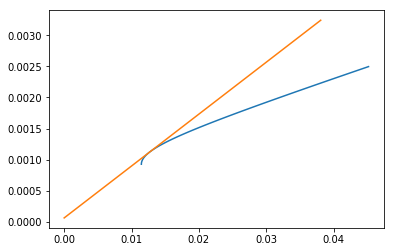

In [53]:
plt.plot(frontera['Vol'], frontera['Media'])
plt.plot(LAC['Vol'], LAC['Media'])